# Libraries 

In [1]:
# trio!
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

import seaborn as sns
import timeit

# ML
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import learning_curve

# Import Train/Test Set

This time we use sampling to reduce training time.

In [2]:
df_train = pd.read_csv('train.csv').sample(10000, random_state=2021)
df_test = pd.read_csv('test.csv').sample(3000, random_state=2021)

In [3]:
features_list = ['ambient', 'coolant', 'u_d', 'u_q', 'motor_speed', 'i_d', 'i_q']
target = 'stator_yoke'

In [4]:
X_train = df_train[features_list].to_numpy()
y_train = df_train[target].to_numpy()

In [5]:
X_train.shape, y_train.shape

((10000, 7), (10000,))

In [6]:
X_test = df_test[features_list].to_numpy()
y_test = df_test[target].to_numpy()

In [7]:
X_test.shape, y_test.shape

((3000, 7), (3000,))

# Data Preprocessing

In [8]:
X_scaler = MinMaxScaler()

In [9]:
X_train_scaled = X_scaler.fit_transform(X_train)
X_test_scaled = X_scaler.transform(X_test)

# Learning Curve Plot

https://scikit-learn.org/stable/auto_examples/model_selection/plot_learning_curve.html

In [10]:
def plot_learning_curve(estimator, title, X, y, axes=None, ylim=None, cv=None,
                        n_jobs=None, train_sizes=np.linspace(.1, 1.0, 5)):
    """
    Generate 3 plots: the test and training learning curve, the training
    samples vs fit times curve, the fit times vs score curve.

    Parameters
    ----------
    estimator : estimator instance
        An estimator instance implementing `fit` and `predict` methods which
        will be cloned for each validation.

    title : str
        Title for the chart.

    X : array-like of shape (n_samples, n_features)
        Training vector, where ``n_samples`` is the number of samples and
        ``n_features`` is the number of features.

    y : array-like of shape (n_samples) or (n_samples, n_features)
        Target relative to ``X`` for classification or regression;
        None for unsupervised learning.

    axes : array-like of shape (3,), default=None
        Axes to use for plotting the curves.

    ylim : tuple of shape (2,), default=None
        Defines minimum and maximum y-values plotted, e.g. (ymin, ymax).

    cv : int, cross-validation generator or an iterable, default=None
        Determines the cross-validation splitting strategy.
        Possible inputs for cv are:

          - None, to use the default 5-fold cross-validation,
          - integer, to specify the number of folds.
          - :term:`CV splitter`,
          - An iterable yielding (train, test) splits as arrays of indices.

        For integer/None inputs, if ``y`` is binary or multiclass,
        :class:`StratifiedKFold` used. If the estimator is not a classifier
        or if ``y`` is neither binary nor multiclass, :class:`KFold` is used.

        Refer :ref:`User Guide <cross_validation>` for the various
        cross-validators that can be used here.

    n_jobs : int or None, default=None
        Number of jobs to run in parallel.
        ``None`` means 1 unless in a :obj:`joblib.parallel_backend` context.
        ``-1`` means using all processors. See :term:`Glossary <n_jobs>`
        for more details.

    train_sizes : array-like of shape (n_ticks,)
        Relative or absolute numbers of training examples that will be used to
        generate the learning curve. If the ``dtype`` is float, it is regarded
        as a fraction of the maximum size of the training set (that is
        determined by the selected validation method), i.e. it has to be within
        (0, 1]. Otherwise it is interpreted as absolute sizes of the training
        sets. Note that for classification the number of samples usually have
        to be big enough to contain at least one sample from each class.
        (default: np.linspace(0.1, 1.0, 5))
    """
    if axes is None:
        _, axes = plt.subplots(1, 3, figsize=(20, 5))

    axes[0].set_title(title)
    if ylim is not None:
        axes[0].set_ylim(*ylim)
    axes[0].set_xlabel("Training examples")
    axes[0].set_ylabel("Score")

    train_sizes, train_scores, test_scores, fit_times, _ = \
        learning_curve(estimator, X, y, cv=cv, n_jobs=n_jobs,
                       train_sizes=train_sizes,
                       return_times=True)
    train_scores_mean = np.mean(train_scores, axis=1)
    train_scores_std = np.std(train_scores, axis=1)
    test_scores_mean = np.mean(test_scores, axis=1)
    test_scores_std = np.std(test_scores, axis=1)
    fit_times_mean = np.mean(fit_times, axis=1)
    fit_times_std = np.std(fit_times, axis=1)

    # Plot learning curve
    axes[0].grid()
    axes[0].fill_between(train_sizes, train_scores_mean - train_scores_std,
                         train_scores_mean + train_scores_std, alpha=0.1,
                         color="r")
    axes[0].fill_between(train_sizes, test_scores_mean - test_scores_std,
                         test_scores_mean + test_scores_std, alpha=0.1,
                         color="g")
    axes[0].plot(train_sizes, train_scores_mean, 'o-', color="r",
                 label="Training score")
    axes[0].plot(train_sizes, test_scores_mean, 'o-', color="g",
                 label="Cross-validation score")
    axes[0].legend(loc="best")

    # Plot n_samples vs fit_times
    axes[1].grid()
    axes[1].plot(train_sizes, fit_times_mean, 'o-')
    axes[1].fill_between(train_sizes, fit_times_mean - fit_times_std,
                         fit_times_mean + fit_times_std, alpha=0.1)
    axes[1].set_xlabel("Training examples")
    axes[1].set_ylabel("fit_times")
    axes[1].set_title("Scalability of the model")

    # Plot fit_time vs score
    axes[2].grid()
    axes[2].plot(fit_times_mean, test_scores_mean, 'o-')
    axes[2].fill_between(fit_times_mean, test_scores_mean - test_scores_std,
                         test_scores_mean + test_scores_std, alpha=0.1)
    axes[2].set_xlabel("fit_times")
    axes[2].set_ylabel("Score")
    axes[2].set_title("Performance of the model")

    return plt

#  Predictive Models

In [11]:
from sklearn.model_selection import GridSearchCV, RandomizedSearchCV

In [12]:
def plot_test(reg, X, y):
    y_pred = reg.predict(X)
    plt.scatter(y, y_pred)
    rmse = mean_squared_error(y, y_pred, squared=False)
    print(f'RMSE: {rmse}')

## Ridge 

In [13]:
from sklearn.linear_model import Ridge

https://scikit-learn.org/stable/modules/generated/sklearn.linear_model.Ridge.html

In [14]:
param_grid_ridge = {
    "alpha": [0.01, 0.2, 0.4, 0.6, 0.8, 1],
    "solver": ["cholesky", "saga"]
}

### Grid Search

In [15]:
grid_search_ridge = GridSearchCV(Ridge(), param_grid_ridge, cv=5, n_jobs=-1)

In [16]:
%timeit grid_search_ridge.fit(X_train_scaled, y_train)

80 ms ± 3.92 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)


In [17]:
grid_search_ridge.best_params_

{'alpha': 0.01, 'solver': 'saga'}

In [18]:
grid_search_ridge.cv_results_

{'mean_fit_time': array([0.00160027, 0.01350117, 0.00210056, 0.01530075, 0.00209966,
        0.0138999 , 0.00179935, 0.01689935, 0.00189834, 0.01570015,
        0.00210004, 0.01319947]),
 'std_fit_time': array([0.0001998 , 0.00164301, 0.00019987, 0.00143516, 0.00019984,
        0.00128012, 0.00074833, 0.00601135, 0.00058227, 0.00380182,
        0.00019965, 0.00143492]),
 'mean_score_time': array([0.00029969, 0.00059934, 0.00029998, 0.00079885, 0.00029984,
        0.00049939, 0.00020041, 0.00059986, 0.00029936, 0.00059962,
        0.00030007, 0.00020008]),
 'std_score_time': array([2.44697619e-04, 1.98865015e-04, 2.44931545e-04, 6.00625466e-04,
        2.44814745e-04, 8.60951905e-07, 2.45457391e-04, 2.00033273e-04,
        2.44427425e-04, 2.00036001e-04, 2.45009196e-04, 2.45048764e-04]),
 'param_alpha': masked_array(data=[0.01, 0.01, 0.2, 0.2, 0.4, 0.4, 0.6, 0.6, 0.8, 0.8, 1,
                    1],
              mask=[False, False, False, False, False, False, False, False,
            

In [19]:
df_grid_search_ridge = pd.DataFrame(grid_search_ridge.cv_results_)
df_grid_search_ridge.head(5)

,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_alpha,param_solver,params,split0_test_score,split1_test_score,split2_test_score,split3_test_score,split4_test_score,mean_test_score,std_test_score,rank_test_score
0,0.001600,0.000200,0.000300,0.000245,0.01,cholesky,"{'alpha': 0.01, 'solver': 'cholesky'}",0.842593,0.845733,0.832234,0.849496,0.850215,0.844054,0.006515,7
1,0.013501,0.001643,0.000599,0.000199,0.01,saga,"{'alpha': 0.01, 'solver': 'saga'}",0.842599,0.845729,0.832232,0.849487,0.850240,0.844057,0.006519,1
2,0.002101,0.000200,0.000300,0.000245,0.2,cholesky,"{'alpha': 0.2, 'solver': 'cholesky'}",0.842599,0.845727,0.832237,0.849499,0.850211,0.844055,0.006513,4
3,0.015301,0.001435,0.000799,0.000601,0.2,saga,"{'alpha': 0.2, 'solver': 'saga'}",0.842609,0.845726,0.832240,0.849503,0.850201,0.844056,0.006510,2
4,0.002100,0.000200,0.000300,0.000245,0.4,cholesky,"{'alpha': 0.4, 'solver': 'cholesky'}",0.842604,0.845720,0.832239,0.849503,0.850207,0.844055,0.006512,5


In [20]:
df_grid_search_ridge.sort_values(["param_solver", "param_alpha", "mean_test_score"], inplace=True)

<AxesSubplot:xlabel='param_alpha', ylabel='mean_test_score'>

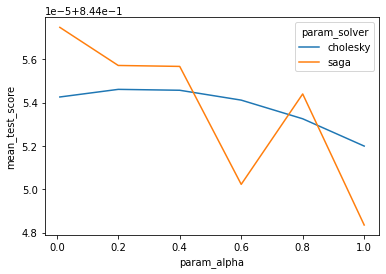

In [21]:
sns.lineplot(x="param_alpha", y="mean_test_score", hue="param_solver", data=df_grid_search_ridge)

In [22]:
grid_search_ridge.score(X_test_scaled, y_test)

0.8331646544452916

RMSE: 0.38619818807965783


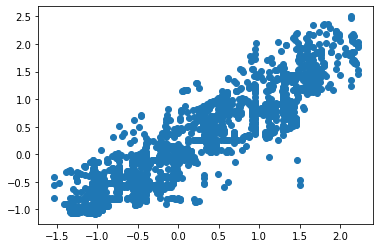

In [23]:
plot_test(grid_search_ridge, X_test_scaled, y_test)

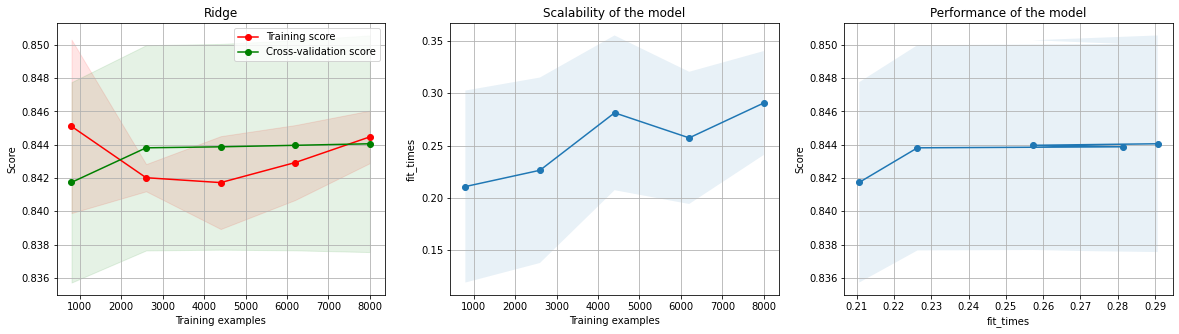

In [24]:
plot_learning_curve(grid_search_ridge, "Ridge", X_train_scaled, y_train, cv=5, n_jobs=-1);

### Randomized Search

In [25]:
rand_search_ridge = RandomizedSearchCV(Ridge(), param_grid_ridge, cv=5, n_jobs=-1)

In [26]:
%timeit rand_search_ridge.fit(X_train_scaled, y_train)

74.5 ms ± 2.89 ms per loop (mean ± std. dev. of 7 runs, 10 loops each)


In [27]:
rand_search_ridge.best_params_

{'solver': 'saga', 'alpha': 0.6}

In [28]:
rand_search_ridge.cv_results_

{'mean_fit_time': array([0.01220083, 0.00160012, 0.01439934, 0.01579981, 0.01710029,
        0.00129952, 0.00160036, 0.00129972, 0.00899963, 0.00129972]),
 'std_fit_time': array([0.00174913, 0.00019903, 0.00171475, 0.00180557, 0.00281741,
        0.00040008, 0.00037414, 0.00040059, 0.00144851, 0.00024478]),
 'mean_score_time': array([0.0006    , 0.00029993, 0.00069985, 0.00049977, 0.00059972,
        0.0004004 , 0.00040021, 0.00050044, 0.00039983, 0.00020008]),
 'std_score_time': array([2.00557765e-04, 2.44892395e-04, 2.45496433e-04, 5.30983387e-07,
        2.00820387e-04, 2.00201011e-04, 2.00105076e-04, 7.07263802e-07,
        1.99914512e-04, 2.45048021e-04]),
 'param_solver': masked_array(data=['saga', 'cholesky', 'saga', 'saga', 'saga', 'cholesky',
                    'cholesky', 'cholesky', 'saga', 'cholesky'],
              mask=[False, False, False, False, False, False, False, False,
                    False, False],
        fill_value='?',
             dtype=object),
 'param_al

In [29]:
df_rand_search_ridge = pd.DataFrame(rand_search_ridge.cv_results_)
df_rand_search_ridge.head(5)

,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_solver,param_alpha,params,split0_test_score,split1_test_score,split2_test_score,split3_test_score,split4_test_score,mean_test_score,std_test_score,rank_test_score
0,0.012201,0.001749,0.0006,2.005578e-04,saga,0.4,"{'solver': 'saga', 'alpha': 0.4}",0.842601,0.845719,0.832254,0.849508,0.850202,0.844057,0.006507,3
1,0.001600,0.000199,0.0003,2.448924e-04,cholesky,0.01,"{'solver': 'cholesky', 'alpha': 0.01}",0.842593,0.845733,0.832234,0.849496,0.850215,0.844054,0.006515,6
2,0.014399,0.001715,0.0007,2.454964e-04,saga,1,"{'solver': 'saga', 'alpha': 1}",0.842613,0.845697,0.832236,0.849513,0.850181,0.844048,0.006508,10
3,0.015800,0.001806,0.0005,5.309834e-07,saga,0.01,"{'solver': 'saga', 'alpha': 0.01}",0.842576,0.845744,0.832234,0.849511,0.850218,0.844057,0.006519,4
4,0.017100,0.002817,0.0006,2.008204e-04,saga,0.8,"{'solver': 'saga', 'alpha': 0.8}",0.842615,0.845705,0.832245,0.849506,0.850215,0.844057,0.006511,2


In [30]:
df_rand_search_ridge.sort_values(["param_solver", "param_alpha", "mean_test_score"], inplace=True)

<AxesSubplot:xlabel='param_alpha', ylabel='mean_test_score'>

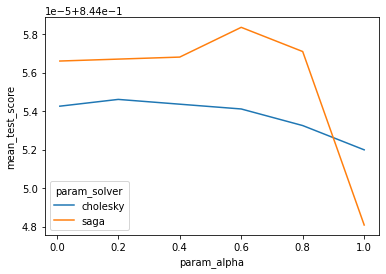

In [31]:
sns.lineplot(x="param_alpha", y="mean_test_score", hue="param_solver", data=df_rand_search_ridge)

In [32]:
rand_search_ridge.score(X_test_scaled, y_test)

0.8329269154546733

RMSE: 0.3864732547380827


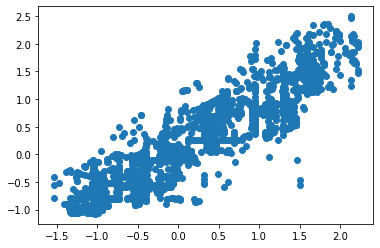

In [33]:
plot_test(rand_search_ridge, X_test_scaled, y_test)

## Lasso

In [34]:
from sklearn.linear_model import Lasso

https://scikit-learn.org/stable/modules/generated/sklearn.linear_model.Lasso.html

In [35]:
param_grid_lasso = {
    "alpha": [0.01, 0.2, 0.4, 0.6, 0.8, 1]
}

In [36]:
grid_search_lasso = GridSearchCV(Lasso(), param_grid=param_grid_lasso, cv=5, n_jobs=-1)

In [37]:
grid_search_lasso.fit(X_train_scaled, y_train)

GridSearchCV(cv=5, estimator=Lasso(), n_jobs=-1,
             param_grid={'alpha': [0.01, 0.2, 0.4, 0.6, 0.8, 1]})

In [38]:
grid_search_lasso.best_params_

{'alpha': 0.01}

In [39]:
grid_search_lasso.cv_results_

{'mean_fit_time': array([0.00140014, 0.00129976, 0.00120006, 0.00129933, 0.00119972,
        0.00109954]),
 'std_fit_time': array([0.00037414, 0.00024482, 0.00024569, 0.00024427, 0.00050994,
        0.0001997 ]),
 'mean_score_time': array([2.00176239e-04, 4.00018692e-04, 4.99868393e-04, 2.00128555e-04,
        9.99927521e-05, 3.00502777e-04]),
 'std_score_time': array([2.45165008e-04, 2.00010788e-04, 8.60951905e-07, 2.45106433e-04,
        1.99985504e-04, 2.45360525e-04]),
 'param_alpha': masked_array(data=[0.01, 0.2, 0.4, 0.6, 0.8, 1],
              mask=[False, False, False, False, False, False],
        fill_value='?',
             dtype=object),
 'params': [{'alpha': 0.01},
  {'alpha': 0.2},
  {'alpha': 0.4},
  {'alpha': 0.6},
  {'alpha': 0.8},
  {'alpha': 1}],
 'split0_test_score': array([ 8.31758611e-01,  1.99375939e-01, -1.58310342e-05, -1.58310342e-05,
        -1.58310342e-05, -1.58310342e-05]),
 'split1_test_score': array([ 0.83686056,  0.20393506, -0.00144456, -0.00144456, -0

In [40]:
df_grid_search_lasso = pd.DataFrame(grid_search_lasso.cv_results_)
df_grid_search_lasso.head(5)

,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_alpha,params,split0_test_score,split1_test_score,split2_test_score,split3_test_score,split4_test_score,mean_test_score,std_test_score,rank_test_score
0,0.001400,0.000374,0.0002,2.451650e-04,0.01,{'alpha': 0.01},0.831759,0.836861,0.825038,0.843773,0.845184,0.836523,0.007514,1
1,0.001300,0.000245,0.0004,2.000108e-04,0.2,{'alpha': 0.2},0.199376,0.203935,0.213555,0.207348,0.203508,0.205544,0.004737,2
2,0.001200,0.000246,0.0005,8.609519e-07,0.4,{'alpha': 0.4},-0.000016,-0.001445,-0.001739,-0.000004,-0.000001,-0.000641,0.000782,3
3,0.001299,0.000244,0.0002,2.451064e-04,0.6,{'alpha': 0.6},-0.000016,-0.001445,-0.001739,-0.000004,-0.000001,-0.000641,0.000782,3
4,0.001200,0.000510,0.0001,1.999855e-04,0.8,{'alpha': 0.8},-0.000016,-0.001445,-0.001739,-0.000004,-0.000001,-0.000641,0.000782,3


In [41]:
df_grid_search_lasso.sort_values(["param_alpha", "mean_test_score"], inplace=True)

<AxesSubplot:xlabel='param_alpha', ylabel='mean_test_score'>

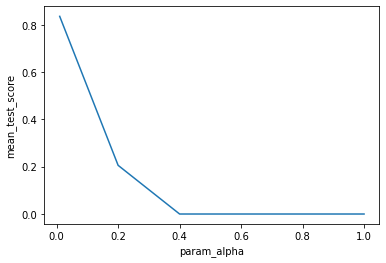

In [42]:
sns.lineplot(x="param_alpha", y="mean_test_score", data=df_grid_search_lasso)

In [43]:
grid_search_lasso.score(X_test_scaled, y_test)

0.8262217629318773

RMSE: 0.3941521436079015


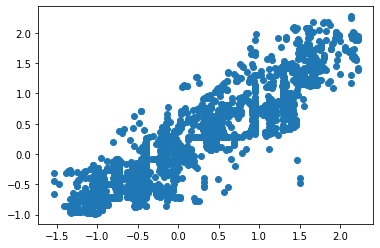

In [44]:
plot_test(grid_search_lasso, X_test_scaled, y_test)

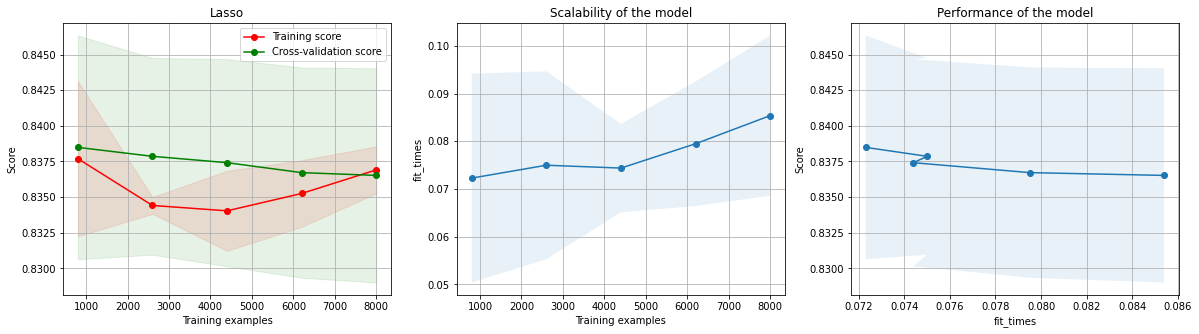

In [45]:
plot_learning_curve(grid_search_lasso, "Lasso", X_train_scaled, y_train, cv=5, n_jobs=-1);

## Decision Tree Regressor 

In [46]:
from sklearn.tree import DecisionTreeRegressor

https://scikit-learn.org/stable/modules/generated/sklearn.tree.DecisionTreeRegressor.html

In [47]:
param_grid_dt_reg = {
    "max_depth": [5, 7, 10, 15, 30],
    "min_samples_split": [2, 5, 10],
    "min_samples_leaf": [1, 10, 20],
}

In [48]:
grid_search_dt_reg = GridSearchCV(DecisionTreeRegressor(), param_grid_dt_reg, cv=5, n_jobs=-1)

In [49]:
grid_search_dt_reg.fit(X_train, y_train)

GridSearchCV(cv=5, estimator=DecisionTreeRegressor(), n_jobs=-1,
             param_grid={'max_depth': [5, 7, 10, 15, 30],
                         'min_samples_leaf': [1, 10, 20],
                         'min_samples_split': [2, 5, 10]})

In [50]:
grid_search_dt_reg.best_params_

{'max_depth': 30, 'min_samples_leaf': 10, 'min_samples_split': 5}

In [51]:
grid_search_dt_reg.cv_results_

{'mean_fit_time': array([0.0260983 , 0.0234992 , 0.02350025, 0.02319951, 0.02519932,
        0.02369919, 0.02349925, 0.02390041, 0.02380013, 0.03179941,
        0.03049941, 0.03029852, 0.02979975, 0.03029971, 0.03139987,
        0.03000035, 0.02969975, 0.02950001, 0.04199953, 0.04379907,
        0.04030046, 0.03839898, 0.03840003, 0.03839993, 0.03709989,
        0.03909898, 0.03649902, 0.05489955, 0.05249901, 0.0502995 ,
        0.04279919, 0.04099956, 0.04170055, 0.03799901, 0.03799939,
        0.03860011, 0.06660028, 0.07730026, 0.08190007, 0.05319986,
        0.04529943, 0.0548996 , 0.04100003, 0.03899903, 0.03369927]),
 'std_fit_time': array([0.00326233, 0.00070709, 0.00083646, 0.00074885, 0.00258045,
        0.0006775 , 0.00094949, 0.000969  , 0.00261908, 0.00300992,
        0.00077439, 0.00081229, 0.00050898, 0.00174908, 0.00390327,
        0.00083671, 0.00087142, 0.00044772, 0.00225927, 0.00693966,
        0.00140002, 0.00149715, 0.0015293 , 0.00128056, 0.00168515,
        0.004

In [52]:
df_grid_search_dt_reg = pd.DataFrame(grid_search_dt_reg.cv_results_)
df_grid_search_dt_reg.head(5)

,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_max_depth,param_min_samples_leaf,param_min_samples_split,params,split0_test_score,split1_test_score,split2_test_score,split3_test_score,split4_test_score,mean_test_score,std_test_score,rank_test_score
0,0.026098,0.003262,0.000800,2.451066e-04,5,1,2,"{'max_depth': 5, 'min_samples_leaf': 1, 'min_s...",0.865384,0.859384,0.850290,0.862312,0.869908,0.861456,0.006581,40
1,0.023499,0.000707,0.000700,2.449121e-04,5,1,5,"{'max_depth': 5, 'min_samples_leaf': 1, 'min_s...",0.865384,0.859384,0.850290,0.862312,0.869908,0.861456,0.006581,40
2,0.023500,0.000836,0.000501,5.840039e-07,5,1,10,"{'max_depth': 5, 'min_samples_leaf': 1, 'min_s...",0.865384,0.859384,0.850290,0.862312,0.869908,0.861456,0.006581,40
3,0.023200,0.000749,0.000500,2.780415e-07,5,10,2,"{'max_depth': 5, 'min_samples_leaf': 10, 'min_...",0.864616,0.859098,0.849729,0.866938,0.869986,0.862074,0.007127,37
4,0.025199,0.002580,0.000900,2.002002e-04,5,10,5,"{'max_depth': 5, 'min_samples_leaf': 10, 'min_...",0.864616,0.859098,0.849729,0.866938,0.869986,0.862074,0.007127,37


In [53]:
df_grid_search_dt_reg.sort_values(["param_max_depth", "param_min_samples_leaf", "param_min_samples_split", "mean_test_score"], inplace=True)

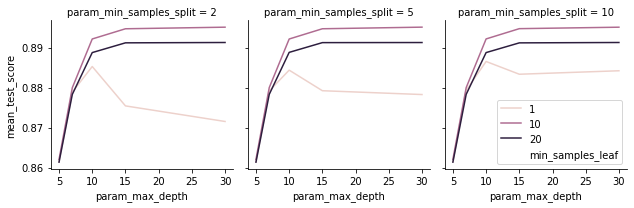

In [54]:
fig_dt_reg = sns.FacetGrid(df_grid_search_dt_reg, col="param_min_samples_split")
fig_dt_reg.map(sns.lineplot, "param_max_depth", "mean_test_score", "param_min_samples_leaf")
plt.plot([], [], ' ', label="min_samples_leaf")
plt.legend()
plt.show()

In [55]:
grid_search_dt_reg.score(X_test, y_test)

0.6621964380107025

RMSE: 0.549538737449912


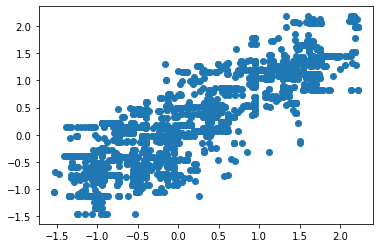

In [56]:
plot_test(grid_search_dt_reg, X_test, y_test)

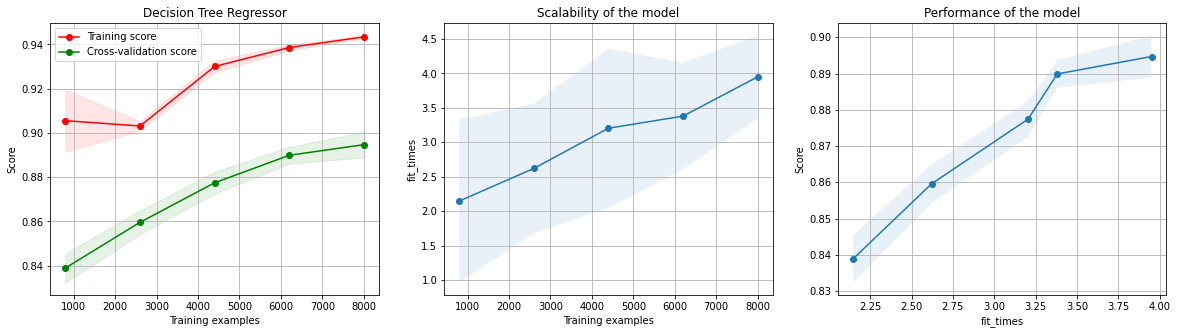

In [57]:
plot_learning_curve(grid_search_dt_reg, "Decision Tree Regressor", X_train_scaled, y_train, cv=5, n_jobs=-1);

## Random Forest Regressor

In [58]:
from sklearn.ensemble import RandomForestRegressor

In [59]:
param_grid_rf_reg = {
    "max_depth": [5, 7, 10, 20],
    "min_samples_split": [2, 5, 10],
    "min_samples_leaf": [1, 10, 20],
}

In [60]:
grid_search_rf_reg = GridSearchCV(RandomForestRegressor(), param_grid_rf_reg, cv=5, n_jobs=-1)

In [61]:
grid_search_rf_reg.fit(X_train, y_train)

GridSearchCV(cv=5, estimator=RandomForestRegressor(), n_jobs=-1,
             param_grid={'max_depth': [5, 7, 10, 20],
                         'min_samples_leaf': [1, 10, 20],
                         'min_samples_split': [2, 5, 10]})

In [62]:
grid_search_rf_reg.best_params_

{'max_depth': 20, 'min_samples_leaf': 1, 'min_samples_split': 2}

In [63]:
grid_search_rf_reg.cv_results_

{'mean_fit_time': array([1.664499  , 1.68289943, 1.61979904, 1.65259991, 1.60899963,
        1.58899961, 1.56990128, 1.65550041, 1.61490016, 2.13469996,
        2.00620022, 1.9900003 , 1.98159966, 1.97450042, 1.9478992 ,
        1.93110037, 1.90739994, 1.90529957, 2.56800089, 2.60070033,
        2.55379977, 2.39739933, 2.36209993, 2.37239919, 2.26070018,
        2.19540014, 2.2294992 , 3.74749966, 3.49570017, 3.34929938,
        2.59630027, 2.69179988, 2.73439994, 2.38649926, 2.19449949,
        2.05519996]),
 'std_fit_time': array([0.10763851, 0.10070944, 0.07030934, 0.08076984, 0.05855959,
        0.07971032, 0.04774635, 0.05625162, 0.08846901, 0.11645195,
        0.02933012, 0.05057435, 0.03608744, 0.03197129, 0.02241237,
        0.02684325, 0.01476562, 0.01955471, 0.01955976, 0.0441631 ,
        0.02909016, 0.03734439, 0.02311336, 0.03375612, 0.05296547,
        0.01455052, 0.04227449, 0.03197945, 0.05556853, 0.03668002,
        0.06125766, 0.15286846, 0.15561289, 0.09293586, 0.093

In [64]:
df_grid_search_rf_reg = pd.DataFrame(grid_search_rf_reg.cv_results_)
df_grid_search_rf_reg.head(5)

,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_max_depth,param_min_samples_leaf,param_min_samples_split,params,split0_test_score,split1_test_score,split2_test_score,split3_test_score,split4_test_score,mean_test_score,std_test_score,rank_test_score
0,1.664499,0.107639,0.012500,0.000447,5,1,2,"{'max_depth': 5, 'min_samples_leaf': 1, 'min_s...",0.874097,0.870702,0.862956,0.878567,0.878134,0.872891,0.005739,32
1,1.682899,0.100709,0.012499,0.000316,5,1,5,"{'max_depth': 5, 'min_samples_leaf': 1, 'min_s...",0.873793,0.871382,0.861681,0.878754,0.878347,0.872792,0.006210,33
2,1.619799,0.070309,0.013400,0.001828,5,1,10,"{'max_depth': 5, 'min_samples_leaf': 1, 'min_s...",0.874270,0.871636,0.862974,0.878931,0.878271,0.873216,0.005774,29
3,1.652600,0.080770,0.013400,0.001357,5,10,2,"{'max_depth': 5, 'min_samples_leaf': 10, 'min_...",0.874363,0.871508,0.862843,0.879839,0.878227,0.873356,0.006012,28
4,1.609000,0.058560,0.012800,0.000979,5,10,5,"{'max_depth': 5, 'min_samples_leaf': 10, 'min_...",0.874398,0.871585,0.862823,0.878705,0.878054,0.873113,0.005754,30


In [65]:
df_grid_search_rf_reg.sort_values(["param_max_depth", "param_min_samples_leaf", "param_min_samples_split", "mean_test_score"], inplace=True)

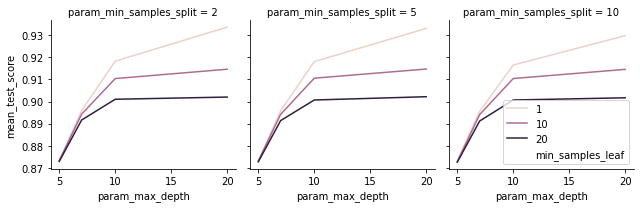

In [66]:
fig_rf_reg = sns.FacetGrid(df_grid_search_rf_reg, col="param_min_samples_split")
fig_rf_reg.map(sns.lineplot, "param_max_depth", "mean_test_score", "param_min_samples_leaf")
plt.plot([], [], ' ', label="min_samples_leaf")
plt.legend()
plt.show()

In [67]:
grid_search_rf_reg.score(X_test, y_test)

0.7635214443831471

RMSE: 0.45979271006606676


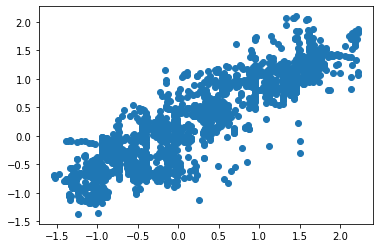

In [68]:
plot_test(grid_search_rf_reg, X_test, y_test)

## AdaBoost Regressor

In [69]:
from sklearn.ensemble import AdaBoostRegressor

In [70]:
param_grid_adb_reg = {
    'n_estimators': [50, 100],
    'learning_rate' : [0.01, 0.2, 0.5, 1],
    'loss' : ['linear', 'square', 'exponential']
 }

In [71]:
grid_search_adb_reg = GridSearchCV(AdaBoostRegressor(), param_grid_adb_reg, cv=5, n_jobs=-1)

In [72]:
grid_search_adb_reg.fit(X_train, y_train)

GridSearchCV(cv=5, estimator=AdaBoostRegressor(), n_jobs=-1,
             param_grid={'learning_rate': [0.01, 0.2, 0.5, 1],
                         'loss': ['linear', 'square', 'exponential'],
                         'n_estimators': [50, 100]})

In [73]:
grid_search_adb_reg.best_params_

{'learning_rate': 0.2, 'loss': 'exponential', 'n_estimators': 50}

In [74]:
grid_search_adb_reg.cv_results_

{'mean_fit_time': array([0.87440057, 1.81329994, 0.89799991, 1.87729979, 0.99209952,
        1.84509935, 0.81180029, 1.49620018, 0.7990005 , 1.24689975,
        0.83589907, 1.48049917, 0.64769945, 1.02240024, 0.62480059,
        1.09119959, 0.80780005, 1.26980009, 0.51229949, 0.58229852,
        0.51879892, 0.93179941, 0.63179984, 0.88110042]),
 'std_fit_time': array([0.04777908, 0.09396758, 0.07772207, 0.14830078, 0.09692959,
        0.14082145, 0.06991817, 0.10868069, 0.05044562, 0.05091417,
        0.05934842, 0.0414573 , 0.05982275, 0.2295332 , 0.05438048,
        0.11638643, 0.0619067 , 0.08738446, 0.0766131 , 0.10260898,
        0.04272985, 0.10041659, 0.04033523, 0.0837309 ]),
 'mean_score_time': array([0.01310029, 0.02570024, 0.01470022, 0.02379985, 0.00990005,
        0.02520027, 0.01050038, 0.02440019, 0.01169982, 0.02450089,
        0.01250052, 0.02440028, 0.01449976, 0.01949997, 0.01659918,
        0.02509947, 0.01569986, 0.02789989, 0.00849957, 0.0109005 ,
        0.016099

In [75]:
df_grid_search_adb_reg = pd.DataFrame(grid_search_adb_reg.cv_results_)
df_grid_search_adb_reg.head(5)

,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_learning_rate,param_loss,param_n_estimators,params,split0_test_score,split1_test_score,split2_test_score,split3_test_score,split4_test_score,mean_test_score,std_test_score,rank_test_score
0,0.874401,0.047779,0.0131,0.005238,0.01,linear,50,"{'learning_rate': 0.01, 'loss': 'linear', 'n_e...",0.821644,0.808516,0.807521,0.808716,0.820387,0.813357,0.006279,8
1,1.813300,0.093968,0.0257,0.002926,0.01,linear,100,"{'learning_rate': 0.01, 'loss': 'linear', 'n_e...",0.825598,0.816766,0.816179,0.812148,0.822844,0.818707,0.004854,4
2,0.898000,0.077722,0.0147,0.005105,0.01,square,50,"{'learning_rate': 0.01, 'loss': 'square', 'n_e...",0.822424,0.822774,0.809092,0.808017,0.818983,0.816258,0.006437,6
3,1.877300,0.148301,0.0238,0.002804,0.01,square,100,"{'learning_rate': 0.01, 'loss': 'square', 'n_e...",0.820233,0.823100,0.811178,0.818396,0.821304,0.818842,0.004125,3
4,0.992100,0.096930,0.0099,0.000583,0.01,exponential,50,"{'learning_rate': 0.01, 'loss': 'exponential',...",0.820497,0.809846,0.803933,0.808793,0.820204,0.812655,0.006593,9


In [76]:
df_grid_search_adb_reg.sort_values(["param_loss", "param_learning_rate", "param_n_estimators", "mean_test_score"], inplace=True)

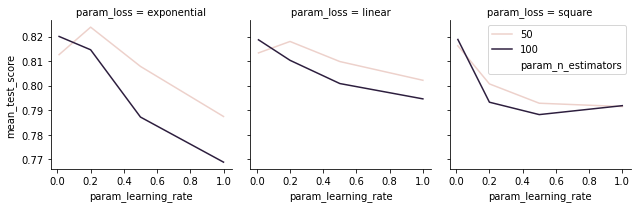

In [77]:
fig_adb_reg = sns.FacetGrid(df_grid_search_adb_reg, col="param_loss")
fig_adb_reg.map(sns.lineplot, "param_learning_rate", "mean_test_score", "param_n_estimators")
plt.plot([], [], ' ', label="param_n_estimators")
plt.legend()
plt.show()

In [78]:
grid_search_adb_reg.score(X_test, y_test)

0.7053345953622785

RMSE: 0.5132521465744666


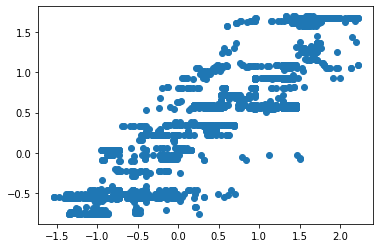

In [79]:
plot_test(grid_search_adb_reg, X_test, y_test)

## Gradient Boosting Regressor 

In [80]:
from sklearn.ensemble import GradientBoostingRegressor

In [81]:
param_grid_gb_reg = {
    "n_estimators": [50, 100, 200, 500],
    "max_depth": [5, 7, 10]
}

In [82]:
grid_search_gb_reg = GridSearchCV(GradientBoostingRegressor(), param_grid_gb_reg, cv=5, n_jobs=-1)

In [83]:
grid_search_gb_reg.fit(X_train, y_train)

GridSearchCV(cv=5, estimator=GradientBoostingRegressor(), n_jobs=-1,
             param_grid={'max_depth': [5, 7, 10],
                         'n_estimators': [50, 100, 200, 500]})

In [84]:
grid_search_gb_reg.best_params_

{'max_depth': 10, 'n_estimators': 500}

In [85]:
grid_search_gb_reg.cv_results_

{'mean_fit_time': array([ 1.21049886,  2.50219984,  5.06089945, 12.64259977,  1.61780009,
         3.37540021,  6.89129877, 17.4396996 ,  2.13570056,  4.57679992,
         9.54040031, 21.29809961]),
 'std_fit_time': array([0.01368598, 0.0278798 , 0.03725639, 0.07461732, 0.01129477,
        0.04860834, 0.05240515, 0.07210501, 0.01925792, 0.02425438,
        0.04618502, 0.52722695]),
 'mean_score_time': array([0.00290003, 0.00429974, 0.00750012, 0.01590037, 0.00409951,
        0.0066    , 0.01030107, 0.02060027, 0.00729995, 0.01039972,
        0.02030001, 0.02730002]),
 'std_score_time': array([0.00019999, 0.00024536, 0.00031628, 0.00019991, 0.00020032,
        0.00049011, 0.00040034, 0.0015933 , 0.00060055, 0.00019987,
        0.00665227, 0.00112273]),
 'param_max_depth': masked_array(data=[5, 5, 5, 5, 7, 7, 7, 7, 10, 10, 10, 10],
              mask=[False, False, False, False, False, False, False, False,
                    False, False, False, False],
        fill_value='?',
         

In [86]:
df_grid_search_gb_reg = pd.DataFrame(grid_search_gb_reg.cv_results_)
df_grid_search_gb_reg.head(5)

,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_max_depth,param_n_estimators,params,split0_test_score,split1_test_score,split2_test_score,split3_test_score,split4_test_score,mean_test_score,std_test_score,rank_test_score
0,1.210499,0.013686,0.0029,0.000200,5,50,"{'max_depth': 5, 'n_estimators': 50}",0.899784,0.896592,0.890382,0.901945,0.903545,0.898450,0.004658,12
1,2.502200,0.027880,0.0043,0.000245,5,100,"{'max_depth': 5, 'n_estimators': 100}",0.908349,0.903694,0.899342,0.907176,0.910836,0.905879,0.003996,11
2,5.060899,0.037256,0.0075,0.000316,5,200,"{'max_depth': 5, 'n_estimators': 200}",0.916880,0.911137,0.908927,0.913992,0.920979,0.914383,0.004247,10
3,12.642600,0.074617,0.0159,0.000200,5,500,"{'max_depth': 5, 'n_estimators': 500}",0.924786,0.918681,0.918782,0.921832,0.929520,0.922720,0.004077,7
4,1.617800,0.011295,0.0041,0.000200,7,50,"{'max_depth': 7, 'n_estimators': 50}",0.918855,0.913347,0.912370,0.915307,0.923814,0.916739,0.004176,9


In [87]:
df_grid_search_gb_reg.sort_values(["param_max_depth", "param_n_estimators", "mean_test_score"], inplace=True)

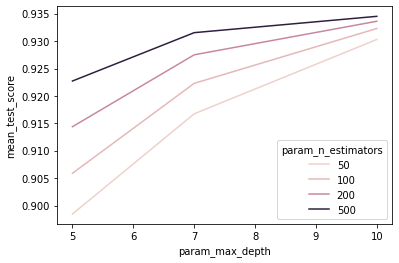

In [88]:
sns.lineplot(x="param_max_depth", y="mean_test_score", hue="param_n_estimators", data=df_grid_search_gb_reg);

In [89]:
grid_search_gb_reg.score(X_test, y_test)

0.7666378329119824

RMSE: 0.45675301611697594


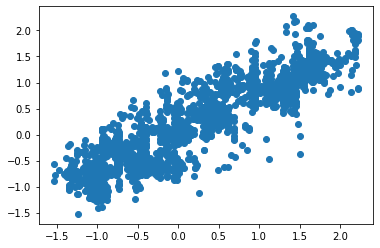

In [90]:
plot_test(grid_search_gb_reg, X_test, y_test)

## XGBoost Regressor

In [91]:
from xgboost import XGBRegressor

In [92]:
param_grid_xgb_reg = {
    'min_child_weight': [1, 5, 10],
    'subsample': [0.6, 0.8, 1.0],
    'max_depth': [3, 4, 5]
}

In [93]:
grid_search_xgb_reg = GridSearchCV(XGBRegressor(), param_grid_xgb_reg, cv=5, n_jobs=-1)

In [94]:
grid_search_xgb_reg.fit(X_train, y_train)

GridSearchCV(cv=5,
             estimator=XGBRegressor(base_score=None, booster=None,
                                    colsample_bylevel=None,
                                    colsample_bynode=None,
                                    colsample_bytree=None, gamma=None,
                                    gpu_id=None, importance_type='gain',
                                    interaction_constraints=None,
                                    learning_rate=None, max_delta_step=None,
                                    max_depth=None, min_child_weight=None,
                                    missing=nan, monotone_constraints=None,
                                    n_estimators=100, n_jobs=None,
                                    num_parallel_tree=None, random_state=None,
                                    reg_alpha=None, reg_lambda=None,
                                    scale_pos_weight=None, subsample=None,
                                    tree_method=None, validate_para

In [95]:
grid_search_xgb_reg.best_params_

{'max_depth': 5, 'min_child_weight': 5, 'subsample': 1.0}

In [96]:
grid_search_xgb_reg.cv_results_

{'mean_fit_time': array([1.01389914, 1.01429944, 0.91449981, 0.89409842, 0.87379975,
        0.85169783, 0.86140008, 0.8576004 , 0.84129992, 1.14649982,
        1.16230016, 1.14079981, 1.11709981, 1.14059978, 1.11479993,
        1.10850048, 1.13109941, 1.08879986, 1.47269869, 1.42939949,
        1.42549872, 1.3921    , 1.46939969, 1.46149979, 1.37069955,
        1.3272994 , 1.05669951]),
 'std_fit_time': array([0.04546482, 0.04106445, 0.07507206, 0.00478841, 0.02798698,
        0.01186355, 0.01020485, 0.02037516, 0.00598877, 0.03883771,
        0.00873883, 0.02394088, 0.02194642, 0.00684373, 0.02791866,
        0.00710587, 0.02471113, 0.01284413, 0.0133348 , 0.04173653,
        0.02420153, 0.02594131, 0.00891845, 0.00882696, 0.04319441,
        0.06145703, 0.18318623]),
 'mean_score_time': array([0.00320044, 0.00340037, 0.00490012, 0.0036006 , 0.00360112,
        0.00330009, 0.00370021, 0.00309968, 0.0037004 , 0.00350008,
        0.00400019, 0.00410023, 0.00400023, 0.00329981, 0.003700

In [97]:
df_grid_search_xgb_reg = pd.DataFrame(grid_search_xgb_reg.cv_results_)
df_grid_search_xgb_reg.head(5)

,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_max_depth,param_min_child_weight,param_subsample,params,split0_test_score,split1_test_score,split2_test_score,split3_test_score,split4_test_score,mean_test_score,std_test_score,rank_test_score
0,1.013899,0.045465,0.003200,0.000401,3,1,0.6,"{'max_depth': 3, 'min_child_weight': 1, 'subsa...",0.896140,0.896279,0.891209,0.895020,0.902319,0.896193,0.003571,26
1,1.014299,0.041064,0.003400,0.000583,3,1,0.8,"{'max_depth': 3, 'min_child_weight': 1, 'subsa...",0.898766,0.896295,0.890382,0.900699,0.903146,0.897858,0.004363,19
2,0.914500,0.075072,0.004900,0.002853,3,1,1,"{'max_depth': 3, 'min_child_weight': 1, 'subsa...",0.899948,0.894789,0.888521,0.899941,0.900734,0.896787,0.004644,25
3,0.894098,0.004788,0.003601,0.000199,3,5,0.6,"{'max_depth': 3, 'min_child_weight': 5, 'subsa...",0.896402,0.897204,0.889157,0.896777,0.904630,0.896834,0.004900,24
4,0.873800,0.027987,0.003601,0.000200,3,5,0.8,"{'max_depth': 3, 'min_child_weight': 5, 'subsa...",0.898950,0.895122,0.889911,0.898914,0.904863,0.897552,0.004930,21


In [98]:
df_grid_search_xgb_reg.sort_values(["param_min_child_weight", "param_subsample", "param_max_depth", "mean_test_score"], inplace=True)

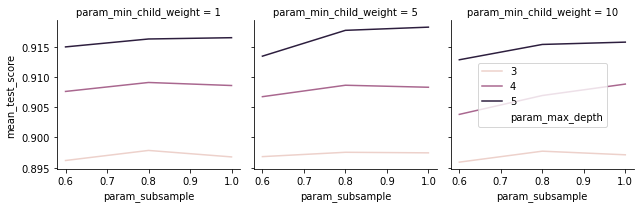

In [99]:
fig_xgb_reg = sns.FacetGrid(df_grid_search_xgb_reg, col="param_min_child_weight")
fig_xgb_reg.map(sns.lineplot, "param_subsample", "mean_test_score", "param_max_depth")
plt.plot([], [], ' ', label="param_max_depth")
plt.legend()
plt.show()

In [100]:
grid_search_xgb_reg.score(X_test, y_test)

0.8103144834477073

RMSE: 0.41179710113879536


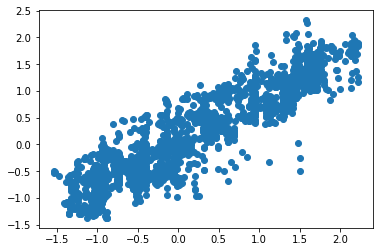

In [101]:
plot_test(grid_search_xgb_reg, X_test, y_test)